## I - Build a classifier with Tensorflow
---
Setup Tensorflow backend to classify *Iris genus* plants.

In [1]:
from __future__ import (absolute_import, 
                        division, 
                        print_function,
                        unicode_literals)
import json
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import pandas as pd
import os
import tensorflow as tf


print(f"TensorFlow version: {tf.__version__}\n\
Eager execution: {tf.executing_eagerly()}")

TensorFlow version: 2.0.0
Eager execution: True


In [2]:
# Helper functions
def pack_features_vector(features, labels):
    """
    Pack the features into a single array.
    Takes values from a list of tensors and creates
    combined tensor at the specified dimension.
    """
    features = tf.stack(list(features.values()), axis=1)
    return features, labels


def loss(model, x, y):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    # predictions
    y_ = model(x)
    # return cross-entropy (actual and predicted)
    return loss_object(y_true=y, y_pred=y_)


def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        # internal call to loss
        loss_value = loss(model, inputs, targets)
    # returns loss and gradients
    return loss_value, tape.gradient(loss_value, model.trainable_variables)


The *Iris genus* entails about 300 species,
but our program will only classify the following three:
 - *Iris setosa*
 - *Iris virginica*
 - *Iris versicolor*  

Load train and test set and look at the first rows of data with pandas:

```python
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

train_dataset_fp = tf.keras.utils.get_file(
    fname=os.path.basename(train_dataset_url),
    origin=train_dataset_url
    )
test_fp = tf.keras.utils.get_file(
    fname=os.path.basename(test_url),
    origin=test_url
    )

column_names = ['sepal_length',
                'sepal_width',
                'petal_length',
                'petal_width',
                'species']

train_df = pd.read_csv(train_dataset_fp,
                       names=column_names,
                       header=0)
train_df.head()
```

The *Iris genus* entails about 300 species,
but our program will only classify the following three:
 - *Iris setosa*
 - *Iris virginica*
 - *Iris versicolor*  

Load train and test set and look at the first rows of data with pandas:

```python
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

train_dataset_fp = tf.keras.utils.get_file(
    fname=os.path.basename(train_dataset_url),
    origin=train_dataset_url
    )
test_fp = tf.keras.utils.get_file(
    fname=os.path.basename(test_url),
    origin=test_url
    )

column_names = ['sepal_length',
                'sepal_width',
                'petal_length',
                'petal_width',
                'species']

train_df = pd.read_csv(train_dataset_fp,
                       names=column_names,
                       header=0)
train_df.head()
```

In [3]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

# Define filepaths for train and test set
train_dataset_fp = tf.keras.utils.get_file(
    fname=os.path.basename(train_dataset_url),
    origin=train_dataset_url
    )

test_fp = tf.keras.utils.get_file(
    fname=os.path.basename(test_url),
    origin=test_url
    )

In [4]:
# Look at the first 5 lines of the dataset
with open(train_dataset_fp) as f:
    for x in range(5):
        head = next(f).strip()
        print(head)

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [5]:
# Columns order in the csv file
column_names = ['sepal_length',
                'sepal_width',
                'petal_length',
                'petal_width',
                'species']

# Load data in a Pandas DataFrame
train_df = pd.read_csv(train_dataset_fp,
                       names=column_names,
                       header=0)

train_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


Each label is associated with a string name (for example, *setosa*),
but machine learning typically relies on numeric values
(**0, 1, 2** in this case)

In [6]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

# Number of examples in a 'batch' (one iteration of model training)
batch_size = 32
feature_names = column_names[:-1]
label_name = column_names[-1]

---
### Prepare data for TensorFlow
Calling ```make_csv_dataset``` to create a **tf.data.Dataset**.

The ```make_csv_dataset``` function returns a **tf.data.Dataset** of (features, label) pairs, where ```features``` is a dictionary: ```{'feature_name': value}```

In [7]:
train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1
    )

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


```Dataset``` objects are iterable.
Like-features are grouped together or *batched* and each example row fields are appended to the corresponding feature array.  
Changing ```batch_size``` in ```make_csv_dataset``` sets the number of examples stored in these feature arrays.

In [8]:
# Look at the next item in the Dataset object
features, labels = next(iter(train_dataset))
features

OrderedDict([('sepal_length',
              <tf.Tensor: id=68, shape=(32,), dtype=float32, numpy=
              array([4.9, 4.4, 4.7, 7.9, 5.2, 5.2, 6.9, 4.6, 5.1, 6.2, 6.5, 5.9, 5.7,
                     7. , 5.6, 7.7, 7.4, 5.1, 4.6, 6.7, 6.2, 6.3, 6.5, 5.5, 5. , 6.8,
                     7.3, 5.7, 6.3, 6.6, 5.8, 6.5], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=69, shape=(32,), dtype=float32, numpy=
              array([2.5, 3.2, 3.2, 3.8, 3.5, 3.4, 3.2, 3.4, 3.8, 2.8, 2.8, 3.2, 3. ,
                     3.2, 2.7, 2.8, 2.8, 2.5, 3.6, 3.1, 3.4, 3.3, 3. , 2.6, 3.5, 3.2,
                     2.9, 4.4, 2.7, 2.9, 2.7, 3.2], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=66, shape=(32,), dtype=float32, numpy=
              array([4.5, 1.3, 1.6, 6.4, 1.5, 1.4, 5.7, 1.4, 1.9, 4.8, 4.6, 4.8, 4.2,
                     4.7, 4.2, 6.7, 6.1, 3. , 1. , 5.6, 5.4, 4.7, 5.8, 4.4, 1.6, 5.9,
                     6.3, 1.5, 4.9, 4.6, 5.1, 5.1],

Explore data with a scatter plot. 
Some clusters are visible by plotting a few features from the batch.

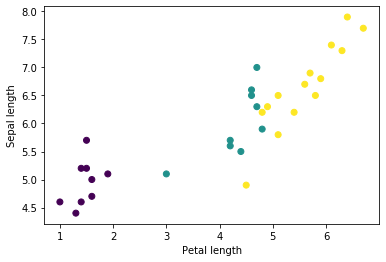

In [9]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

Pack the features in a single arrays with shape ```(batch_size, num_features)``` using ```pack_features_vector``` helper function, then use ```tf.data.Dataset.map``` to pack the features of each
```(features, label)```pair into the training dataset
(it applies the function to each pair).

The features element of the ```Dataset``` are now arrays with shape
```(batch_size, num_features)```.

In [10]:
train_dataset = train_dataset.map(pack_features_vector)

features, labels = next(iter(train_dataset))

In [11]:
# let's look at the first 5 examples (i.e. samples)
print(features[:5])

tf.Tensor(
[[6.5 3.2 5.1 2. ]
 [5.6 2.5 3.9 1.1]
 [5.7 4.4 1.5 0.4]
 [5.6 2.9 3.6 1.3]
 [6.3 3.3 6.  2.5]], shape=(5, 4), dtype=float32)


In [12]:
# The target labels for each example in the batch
print(labels[:5])

tf.Tensor([2 1 0 1 2], shape=(5,), dtype=int32)


---
### Select the model

A model is a relationship between the features and the label.

We'll use a neural network to solve the Iris classification problem.   
Neural networks can find complex relationships between features and the label. 

It is a highly-structured graph, organized into one or more hidden layers. 
Each hidden layer consists of one or more neurons. 
There are several categories of neural networks and this program uses a dense, 
or fully-connected neural network: the neurons in one layer receive
input connections from every neuron in the previous layer.  

When the model from is trained and fed an unlabeled example, 
it yields three predictions: the likelihood that this flower is 
the given Iris species. This prediction is called **inference**.

<img src='https://www.tensorflow.org/images/custom_estimators/full_network.png'>

---
### Create a model using Keras

The ```tf.keras.Sequential``` model is a linear stack of layers.  
Its constructor takes a list of layer instances, in this case, two Dense layers with 10 nodes each,
and an output layer with 3 nodes representing our label predictions.  

The first layer's ```input_shape``` parameter corresponds to the number of features from the dataset, 
and is required.

In [13]:
model = tf.keras.Sequential([
  # Input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

The activation function determines the output shape of each node in the layer. 
The ideal number of hidden layers and neurons depends on the problem and the dataset.
> **Rule of thumb**. Increasing the number of hidden layers and neurons creates a more powerful model, 
> which requires more data to train effectively.

#### Using the model
Passing ```features``` in the model calculates predictions for each
example in the batch (in our case we have 32 examples per batch).  
For each example we obtain a logit for each class in the target label.

In [14]:
predictions = model(features)
predictions[0:3]

<tf.Tensor: id=235, shape=(3, 3), dtype=float32, numpy=
array([[ 5.394518 , -3.0335264, -5.5991325],
       [ 4.272182 , -2.440144 , -4.480436 ],
       [ 3.7527742, -2.050967 , -3.8818436]], dtype=float32)>

Using ```softmax``` converts the logit to the predicted probability of 
each example in the batch to be of one of the classes.

In [15]:
tf.nn.softmax(predictions[:3])

<tf.Tensor: id=240, shape=(3, 3), dtype=float32, numpy=
array([[9.9976462e-01, 2.1859721e-04, 1.6804130e-05],
       [9.9862802e-01, 1.2141647e-03, 1.5783020e-04],
       [9.9651259e-01, 3.0057295e-03, 4.8173746e-04]], dtype=float32)>

Calling ```tf.argmax``` on ```predictions``` gives the predicted class index. As the model has not been trained yet, these won't be very good just now.

In [16]:
print(f" Predictions: {tf.argmax(predictions, axis=1)[:5]}")
print(f"Actual label: {labels[:5]}")

 Predictions: [0 0 0 0 0]
Actual label: [2 1 0 1 2]


---
### Train the model
#### Define the loss and gradient function
Both training and evaluation stages need to calculate the model's loss.
This measures how off a model's predictions are from the desired label, or 
in other words, how bad the model is performing.
We want to minimize, or optimize, this value. 

Our model will calculate its loss using ```tf.keras.losses.SparseCategoricalCrossentropy```
which takes the model's class probability predictions and the desired label, and returns the average loss across the examples.

```python
def loss(model, x, y):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    # predictions
    y_ = model(x)
    # return cross-entropy (actual and predicted)
    return loss_object(y_true=y, y_pred=y_)
```

In [17]:
# Using the loss helper function
crossentropy_loss = loss(model, features, labels)
print(f"Loss test: {crossentropy_loss:.2f}")

Loss test: 5.95


```tf.GradientTape``` calculates gradients used to optimise the model.

```python
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        # internal call to loss
        loss_value = loss(model, inputs, targets)
    # returns loss and gradients
    return loss_value, tape.gradient(loss_value, model.trainable_variables)
``` 

#### Create an optimiser

An *optimizer* applies the computed gradients to the model's variables
to minimize the ```loss``` function.

> ##### Gradient descent.
The loss function can be thinked of as a curved surface.
We want to find its lowest point by walking around.

TensorFlow ```tf.train.GradientDescentOptimizer```
implements the stochastic gradient descent (SGD) algorithm.

```python
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
```

The *hyperparameter* ```learning_rate``` sets the step size to take
for each iteration down the hill.

//img src='https://cs231n.github.io/assets/nn3/opt1.gif'>

```grad``` calculates gradients and loss value.  By iteratively
calculating the loss and gradient for each batch, we'll adjust the model
during training.  
Gradually, the model will find the best combination of weights and bias
to minimize loss.

In [18]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_value, gradients = grad(model, features, labels)

# Print the initial loss, no optimisation
print(f"Step: {optimizer.iterations.numpy()} \
           \nInitial Loss: {loss_value.numpy()}")


# Calculate a single optimisation step
optimizer.apply_gradients(zip(gradients, model.trainable_variables))
print(f"Step:  {optimizer.iterations.numpy()} \
           \nLoss: {loss(model, features, labels).numpy()}")

Step: 0            
Initial Loss: 5.9536848068237305
Step:  1            
Loss: 4.647540092468262


#### Training loop
The model is ready for training.  
A *training loop* feeds the dataset examples into the ```model```
to help it make better predictions.  

The following code sets up these *training steps*:
1. Iterate each **epoch**. An epoch is one pass through the dataset.
2. Within an epoch, iterate over each example in the training ```Dataset```
grabbing its ```features``` and (actual)```label```.
3. Using the example features, make a prediction and compare it
with the label. Measure the inaccuracy and use that to calculate the gradients
(via ```grad``` internal call to ```loss```).
4. Use an ```optimizer``` to update the model variables.
5. Keep track of stats for later visualization.

```num_epochs``` is the number of times to loop over the dataset.
> Counter-intuitively, training a model longer does not
guarantee a better model.

In [19]:
# Note: Rerunning this cell uses the same model variables
# Keep results for plotting
train_loss_results = []
train_accuracy_results = []
num_epochs = 201

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Training loop - using batches of 32
    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        # for each batch
        # Add current batch loss 
        epoch_loss_avg(loss_value)
        # Compare predicted label to actual label
        epoch_accuracy(y, model(x))

    # At end epoch append average loss and epoch accuracy
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    # Print results at set number of epochs
    if epoch % 50 == 0:
        print(f"Epoch: {epoch:03d} \
            Loss: {epoch_loss_avg.result():.3f} \
            Accuracy: {epoch_accuracy.result():.3%}")

Epoch: 000             Loss: 3.463             Accuracy: 35.000%
Epoch: 050             Loss: 0.662             Accuracy: 70.000%
Epoch: 100             Loss: 0.399             Accuracy: 87.500%
Epoch: 150             Loss: 0.274             Accuracy: 95.833%
Epoch: 200             Loss: 0.187             Accuracy: 97.500%


#### Visualise the loss function over time

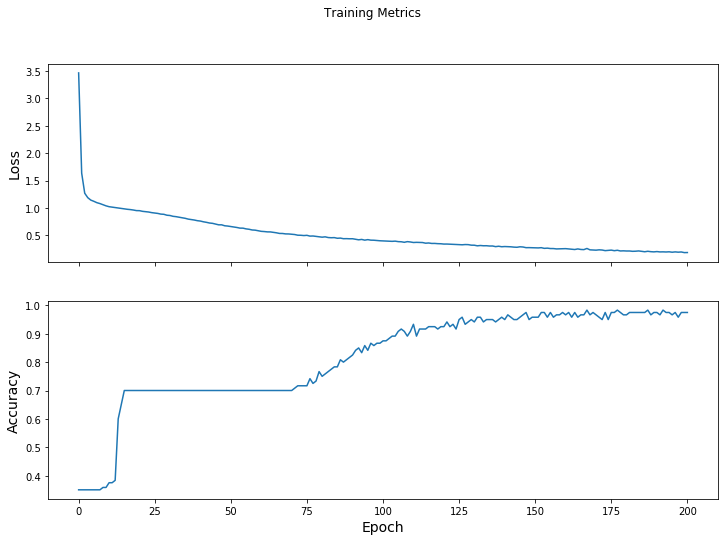

In [20]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

---
### Evaluate the model on the test set
Load the test data in a ```tf.dataset```

In [21]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

The model evaluates only a single epoch of test data.

In [22]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
    logits = model(x)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)

print(f"Test set accuracy: {test_accuracy.result():.3%}")

Test set accuracy: 96.667%


#### Use the model to make predictions
The trained model can be used to make predictions on *unlabeled examples*,
i.e examples that contain a feature but no label.

In [23]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5],
    [5.9, 3.0, 4.2, 1.5],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    p = tf.nn.softmax(logits)[class_idx]
    name = class_names[class_idx]
    print(f"Example {i} prediction: {name} ({100*p:4.1f}%)")

Example 0 prediction: Iris setosa (97.2%)
Example 1 prediction: Iris versicolor (82.7%)
Example 2 prediction: Iris virginica (62.3%)


We can now set up our machine learning model as a web service.

---
## II - Deploy the classifier as a service
Expose Jupyter cells as REST endpoints for front-end consumption.

In [24]:
# Load test data
iris_test_data = pd.read_csv(test_fp,
                             skiprows=[0],
                             names=column_names
                             )


# Encode label classes to string names with np.where(condition, [x, y])
iris_test_data['species'] = np.where(iris_test_data['species'] == 0,
                                     'setosa',
                                     np.where(iris_test_data['species'] == 1,
                                              'versicolor',
                                              'virginica'
                                              ))

iris_test_data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.9,3.0,4.2,1.5,versicolor
1,6.9,3.1,5.4,2.1,virginica
2,5.1,3.3,1.7,0.5,setosa
3,6.0,3.4,4.5,1.6,versicolor
4,5.5,2.5,4.0,1.3,versicolor


First let’s create a function that returns a random Iris flower from the test dataset in our notebook

In [25]:
def show_random_iris():
    """
    Choose a random flowe from 3 possible choices.
    Selects the url for that choice and retrieves the data
    associated with the flower.
    """
    choices = ['setosa', 'versicolor', 'virginica']
    random_flower = random.choice(choices)
    flowers = {
        'setosa': 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg/440px-Kosaciec_szczecinkowaty_Iris_setosa.jpg',
        'versicolor': 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Iris_versicolor_3.jpg/440px-Iris_versicolor_3.jpg',
        'virginica': 'https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/440px-Iris_virginica.jpg'
    }
    random_url = flowers[random_flower]
    single_type = iris_test_data[(iris_test_data['species'] == random_flower)]
    random_row = single_type.sample(n=1).drop(['species'], axis=1)
    final = random_flower, random_url, random_row
    return(final)

We will call this function using an endpoint so our application can fetch a random flower name, its image URL and features data.

#### Setup Kernel Gateway

To turn ```show_random_iris``` into an endpoint we use the Kernel Gateway by wrapping the following around our code:

* a GET comment on the first line of the cell;
* a print command that outputs JSON.

This will make making the function callable from our web application in the browser

In [26]:
# GET /get_random_flower

random_result = show_random_iris()
res = {
    "name" : random_result[0],
    "url" : random_result[1],
    "data" : {"keys" : list(random_result[2]), 
              "values" : random_result[2].iloc[0].tolist()}
}

print(json.dumps(res))

{"name": "versicolor", "url": "https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Iris_versicolor_3.jpg/440px-Iris_versicolor_3.jpg", "data": {"keys": ["sepal_length", "sepal_width", "petal_length", "petal_width"], "values": [5.9, 3.0, 4.2, 1.5]}}


In terminal use this command in the *same directory* of flower_app.ipynb to check out the enpoint.

```python
jupyter kernelgateway --KernelGatewayApp.api='kernel_gateway.notebook_http' --KernelGatewayApp.ip=0.0.0.0 --KernelGatewayApp.port=9090 --KernelGatewayApp.seed_uri=flower_app.ipynb --KernelGatewayApp.allow_origin='*'
```

The command does the following:

* starts Jupyter gateway;
* sets the base URL to localhost (0.0.0.0);
* exposes port 9090 to browsers (you can change this to any available port);
* assigns the flower_power.ipynb notebook to the gateway;
* allows incoming traffic from everywhere (remember, we’re just prototyping)

Open a new tab and point to **localhost:9090/get_random_flower** to get the data returned.

---
If the below error appears, fix the code commenting out the line as below.
AttributeError: module 'signal' has no attribute 'SIGHUP'
https://github.com/hyperopt/hyperopt/issues/332

```python
def start(self):
    """Starts an IO loop for the application."""
    super(KernelGatewayApp, self).start()
    self.log.info(
        'Jupyter Kernel Gateway at http{}://{}:{}'.format(
            's' if self.keyfile else '', self.ip, self.port))
    self.io_loop = ioloop.IOLoop.current()

    # signal.signal(signal.SIGHUP, signal.SIG_IGN)

    signal.signal(signal.SIGTERM, self._signal_stop)

    try:
        self.io_loop.start()
    except KeyboardInterrupt:
        self.log.info("Interrupted...")
    finally:
        self.shutdown()
```



#### Use Swagger to check the endpoint

Jupyter’s Kernel Gateway automatically generates a swagger.json endpoint we can access using SwaggerUI.

Download and install docker and pull Swagger from terminal

```
docker pull swaggerapi/swagger-ui
```

Type docker images in the console to see the name of the image. We can usa that name to run its container

```
docker run -p 80:8080 swaggerapi/swagger-ui
```

Open swagger-ui in our browser on port 80

```
http://localhost:80
```

Add ```http://localhost:9090/_api/spec/swagger.json``` in the explore bar to try out the GET response from the endpoint.



#### Set up other endpoints

In [1]:
class_ids = ['Iris Setosa', 'Iris Versicolor', 'Iris Virginica']

def predict_flower(guess_string):
    guess_list = eval(guess_string)
    predict_dataset = tf.convert_to_tensor([guess_list])
    predictions = model(predict_dataset)
    for i, logits in enumerate(predictions):
        class_idx = tf.argmax(logits).numpy()
        name = class_ids[class_idx]
    return(name)

In [30]:
# GET /predict_flower

req = json.loads(REQUEST)
args = req['args']

guess_string = args['guess_string'][0] # first argument from URL 

predicted_flower = predict_flower(guess_string)

print(json.dumps(predicted_flower))

NameError: name 'REQUEST' is not defined

We are now ready to start prototyping a real application.

---
## III - App prototype setup with Azle

Azle is a front-end prototyping library designed specifically for rapidly crafting applications. 

It uses functions to add and style content, bind events, and interact with API endpoints, making it easier to build full-powered, data-driven applications.

Start by creating an html template creating a index.html file i nthe same directory.

```html
<!DOCTYPE html>
<html>
    
<head>
<script src='https://azlejs.com/v2/azle.min.js'></script>
</head>
    
<body>
</body>
</html>
    
<script> 
 
create_azle(function() {

// YOUR AZLE FUNCTIONS GO HERE

})

</script>
```

All our Azle functions can be added between the ```<script>``` tags at the bottom. 

#### Adding content

Each function uses a target_class and target_instance as the first 2 parameters. This tells Azle where to place the content, or which content we wish to style.

The 3rd parameter is an object containing properties we wish to pass. In our first slider example we passed in a class name (“this_class”) along with default values. 

For example, create a section and add a slider to the section with default, min and max values:

```javascript
az.add_sections({
    "this_class": "my_sections",
    "sections": 1
})
   
    
az.add_slider({"my_sections", 1, {
    "this_class": "my_slider",
    "default_value": 4,
    "min_value": 0,
    "max_value": 10
    })
})    
```

Other elements

```javascript
az.add_button(target_class, target_instance, {
    "this_class" : "my_button",
    "text" : "CLICK ME"
})

    
az.add_dropdown(target_class, target_instance, {
    "this_class" : "my_dropdown",
    "options" : ["option A", 
                 "option B", 
                 "option C", 
                 "option D"],
    "title" : "choose option..."
})


az.add_slider("target_class", 1, {
    "this_class" : "my_slider",
    "default_value" : 4,
    "min_value" : 0,
    "max_value" : 10
})
```

#### Styling content

Styling is done using target_class and target instance as above, and passing style properties into a style object as the 3rd parameter:

```javascript
az.style_button('my_button', 1, {
    "background" : "hotpink",
    "border-radius" : "6px",
    "width" : "200px",
    "color" : "black",
    "cursor" : "wait"
})   
```

#### Adding events

Bind events to our UI elements using the add_event function.

```javascript
az.add_event("my_button", 1, {
    "type" : "click",
    "function" : "alert('you clicked me')"
})  
```

To see all available events run ththis in [jsfiddle](https://jsfiddle.net/)

```javascript
create_azle(function() {

  az.add_sections({
      "this_class" : "my_sections", 
      "sections" : 1
  })
  
  az.add_button("my_sections", 1, {
      "this_class" : "show_icons", 
      "text" : "SHOW EVENTS"
  })
  
  az.add_event('show_icons', 1, {
      "type" : "click", 
      "function" : "az.show_events()"
  })

})
```

#### Calling endpoints

Calling endpoints is how we send and fetch data from REST APIs. Azle’s call_api() function asks for the base url, any parameters we need to pass, and the function to call once the response has been received:

```javascript
// list any parameters required by the API endpoint
params = {
    "postId" : 6
}

az.call_api({
    "url" : "https://jsonplaceholder.typicode.com/comments",
    "parameters" : params,
    "done" : "alert(JSON.stringify(data))"
})
```

---
### Create the app

App folder structure:

```
flower_app
├── scripts
├── d3_visuals
├── flower_power.ipynb
├── index.html
```

We will need to view our application in another browser tab, meaning we need to “spin up a web server.”:

```
python -m http.server
```